In [9]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [10]:
def calculate_uncertainty_Entropy(X, model):
    # Get predicted probabilities for each class
    predicted_probs = model.predict_proba(X)    
    # Check for zero probabilities and replace them with a small value
    predicted_probs[predicted_probs == 0] = 1e-10
    # Calculate uncertainty scores using the entropy
    entropy = -np.sum(predicted_probs * np.log2(predicted_probs), axis=1)
    # Handle the case of uniform probabilities
    entropy[np.isnan(entropy)] = 0    
    return entropy

def calculate_score(lower_probability, upper_probability):
    eps=0.00001
    score = -np.maximum(lower_probability / (1 - lower_probability + eps), (1 - upper_probability) / (upper_probability + eps))
    return score

def Calculate_Credal_Uncertainty(models,Xf):
    uncertainty_scores = []
    # Get the class probabilities for each model
    class_probabilities = np.array([])
    for model in models:
        probabilities = model.predict_proba(Xf)
        if len(class_probabilities)==0: 
            class_probabilities=probabilities[:, 1]
        else:
            class_probabilities=np.c_[class_probabilities,probabilities[:, 1]]  # Probability of class 1
    # Calculate the lower and upper bound probabilities for class 1
    lower_probability = np.min(class_probabilities, axis=1)
    upper_probability = np.max(class_probabilities, axis=1)    
    # Calculate the uncertainty score
    uncertainty_scores = (calculate_score(lower_probability, upper_probability))
    return uncertainty_scores

In [11]:
# Load the Iris dataset
iris = load_iris()
X, y = iris.data[:, :2], iris.target
# Filter the dataset for two classes (class 0 and class 1)
class_indices = np.where((y == 0) | (y == 1))[0]
X= X[class_indices]
y = y[class_indices]
X, y = shuffle(X, y, random_state=42)

In [12]:
# Select initial labeled samples randomly
labeled_indices = np.random.choice(X.shape[0], size=5, replace=False)
unlabeled_indices = np.setdiff1d(np.arange(X.shape[0]), labeled_indices)

In [13]:
# Start the active learning loop
n_iterations = 6
n_samples_per_iteration = 1
# List of models
models = []
num_models = 30  # Number of models to create
rnd_state=np.random.permutation(num_models)

In [15]:
# Train the models
for i in range(0,num_models):    
    model = RandomForestClassifier(random_state=rnd_state[i])
    models.append(model)

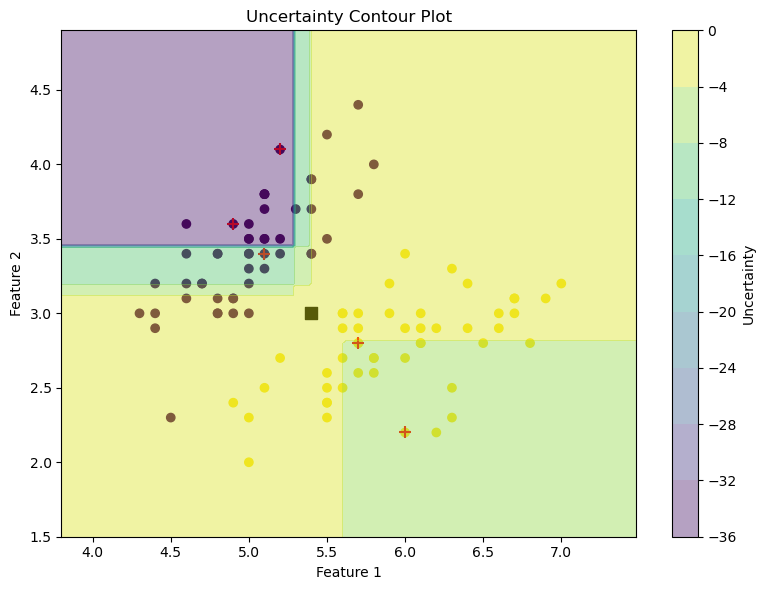

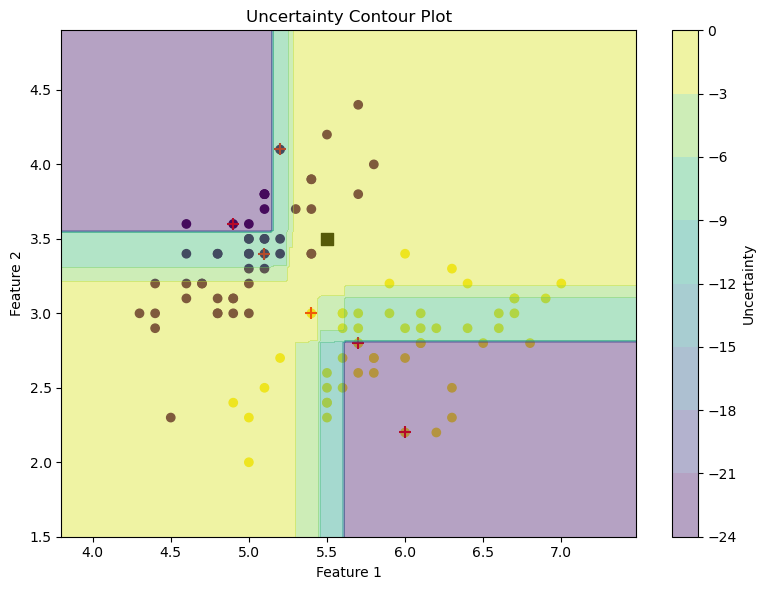

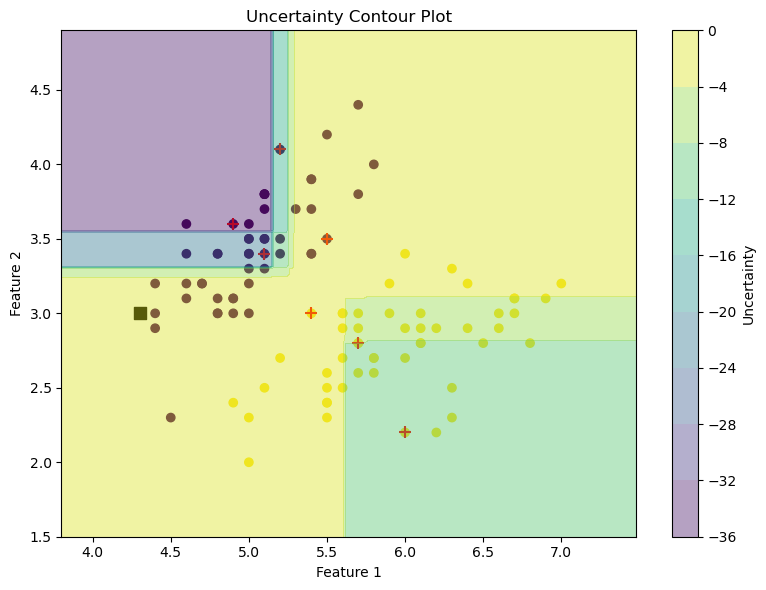

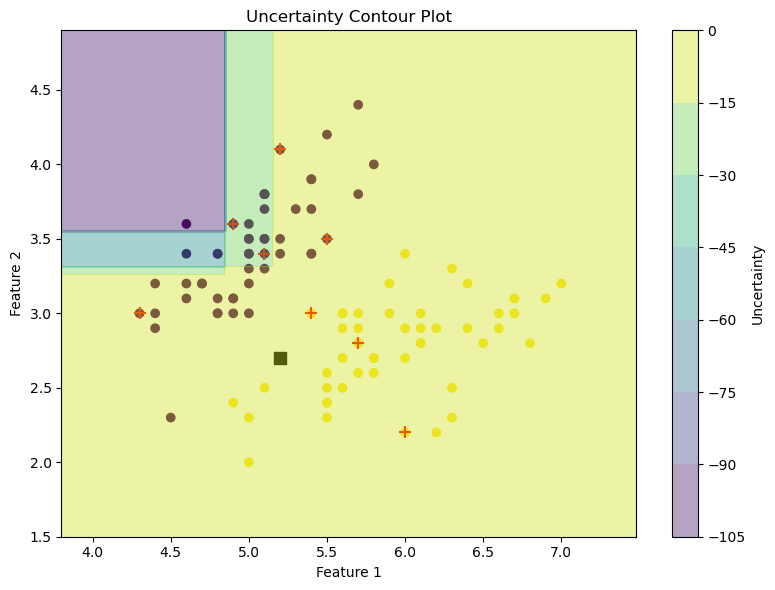

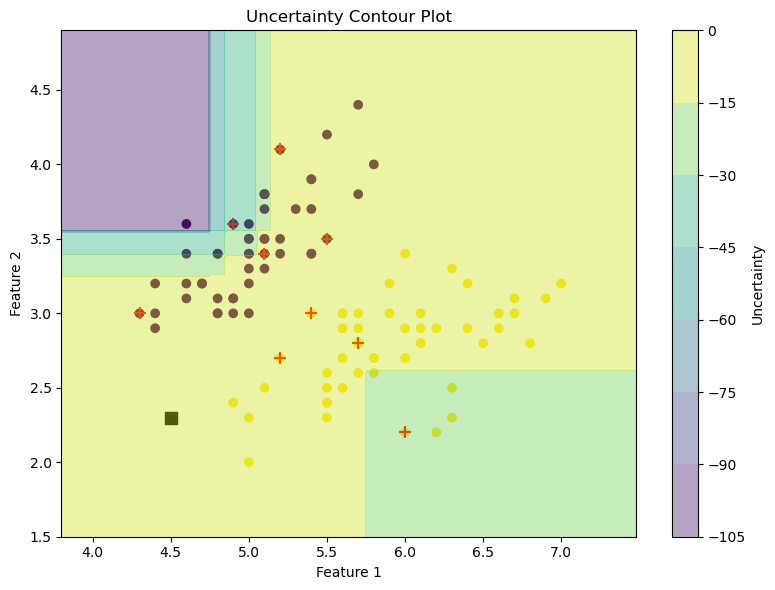

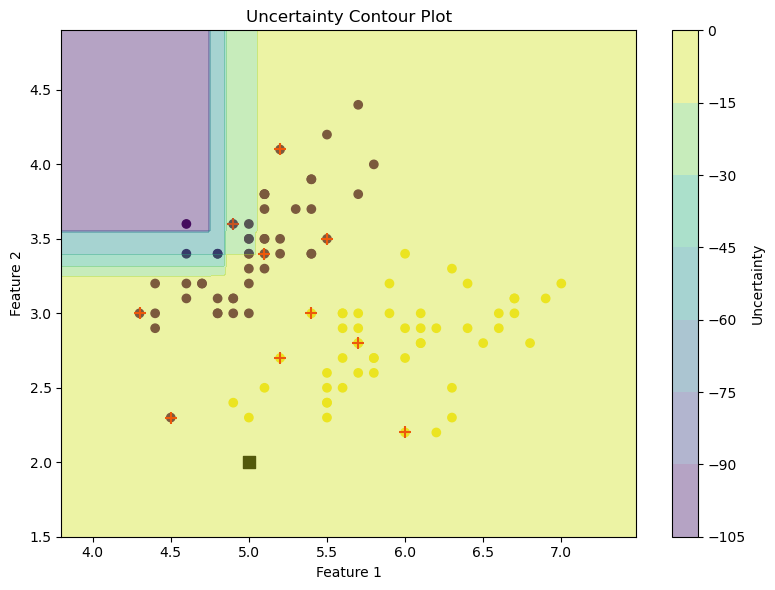

In [16]:
# The loop
for iteration in range(n_iterations):
    trained_models=[]
    for model in models:
        model.fit(X[labeled_indices, :], y[labeled_indices])
        trained_models.append(model)
    
    # Calculate the uncertainty for each data point in the pool
    uncertainty_scores=Calculate_Credal_Uncertainty(trained_models,X[unlabeled_indices])
    idx=np.where(uncertainty_scores==max(uncertainty_scores))
    # Select the indices of the most uncertain samples
    uncertain_indices = np.argsort(uncertainty_scores)[-1] # select the min
    
    # Query labels for the uncertain samples
    queried_indices = unlabeled_indices[uncertain_indices]
    queried_indices = np.array(queried_indices)
    queried_indices = np.reshape(queried_indices, (1,))
    queried_labels = y[queried_indices]
    
    # Add the queried samples to the labeled set
    labeled_indices = np.concatenate((labeled_indices, queried_indices))
    
    # Remove the queried samples from the unlabeled set
    unlabeled_indices = np.setdiff1d(unlabeled_indices, queried_indices)
    
     # contour plot
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    xy_pairs = np.c_[xx.ravel(), yy.ravel()]    
    uncertainty_scores_contour = Calculate_Credal_Uncertainty(trained_models,xy_pairs)
    #min(uncertainty_scores_contour)
    #uncertainties= 1- uncertainty_scores_contour.reshape(xx.shape)
    uncertainties= uncertainty_scores_contour.reshape(xx.shape)

    fig, axs = plt.subplots(figsize=(8, 6))

    # Plot the contour plot of uncertainties
    sc = axs.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
    axs.scatter(X[labeled_indices, 0], X[labeled_indices, 1], marker='+', c='red', cmap='viridis', label='labeled point', s=80)
    axs.scatter(X[queried_indices, 0], X[queried_indices, 1], marker='s', c='blue', label='queried point', s=80)
    contour = axs.contourf(xx, yy, uncertainties, alpha=0.4, cmap='viridis')
    axs.set_xlabel('Feature 1')
    axs.set_ylabel('Feature 2')
    axs.set_title('Uncertainty Contour Plot')
    cbar = fig.colorbar(contour, ax=axs, label='Uncertainty')

    plt.tight_layout()
    plt.show()
